In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms

np.random.seed(0)
torch.manual_seed(0)

# Parameters
batch_size = 16
learning_rate = 0.001
num_epochs = 50  # Set to a higher number to give early stopping a chance to stop earlier if needed
num_classes = 2
patience = 5  # Number of epochs with no improvement after which training will be stopped

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset from folders without transformations initially
full_dataset = datasets.ImageFolder(root='./data')

# Calculate split sizes
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Apply different transforms to training, validation, and test datasets
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load pre-trained Wide ResNet-50-2 model
model = models.wide_resnet50_2(pretrained=True)

# Modify the final layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Move model to GPU if available
device = torch.device('mps')
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

# Validation function
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    epoch_loss = running_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)
    return epoch_loss, accuracy, all_preds, all_labels

# Training loop with early stopping
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, _, _ = evaluate(model, val_loader, criterion, device)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_wts = model.state_dict()
    else:
        epochs_no_improve += 1
    
    # Early stopping
    if epochs_no_improve >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

# Load best model weights
model.load_state_dict(best_model_wts)

# Test the model
test_loss, test_accuracy, test_preds, test_labels = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Epoch 1/50, Train Loss: 0.8426, Val Loss: 104.8183, Val Accuracy: 0.4000
Epoch 2/50, Train Loss: 0.6952, Val Loss: 7.1248, Val Accuracy: 0.8000
Epoch 3/50, Train Loss: 0.6631, Val Loss: 121.7020, Val Accuracy: 0.4000
Epoch 4/50, Train Loss: 0.6843, Val Loss: 4.3341, Val Accuracy: 0.4000
Epoch 5/50, Train Loss: 0.6054, Val Loss: 2.9727, Val Accuracy: 0.6400
Epoch 6/50, Train Loss: 0.5678, Val Loss: 0.9177, Val Accuracy: 0.6800
Epoch 7/50, Train Loss: 0.5276, Val Loss: 5.5019, Val Accuracy: 0.5600
Epoch 8/50, Train Loss: 0.6370, Val Loss: 0.6715, Val Accuracy: 0.7200
Epoch 9/50, Train Loss: 0.5346, Val Loss: 9.8183, Val Accuracy: 0.6000
Epoch 10/50, Train Loss: 0.4811, Val Loss: 4.7098, Val Accuracy: 0.6000
Epoch 11/50, Train Loss: 0.5044, Val Loss: 0.9147, Val Accuracy: 0.7600
Epoch 12/50, Train Loss: 0.5332, Val Loss: 0.4413, Val Accuracy: 0.8000
Epoch 13/50, Train Loss: 0.4937, Val Loss: 0.7815, Val Accuracy: 0.7600
Epoch 14/50, Train Loss: 0.5052, Val Loss: 0.7456, Val Accuracy: 0.72

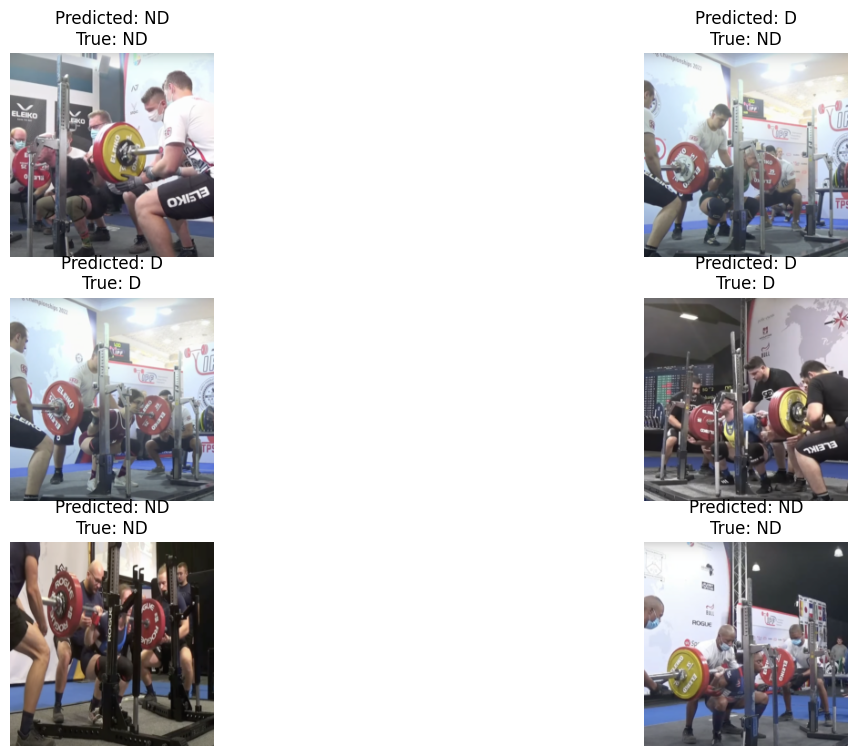

In [8]:
# Function to display a sample of test images with predictions and true labels
def show_test_predictions(model, loader, device, class_names, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 9))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}')
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                img = np.clip(img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)
                ax.imshow(img)

                if images_so_far == num_images:
                    return

# Show a sample of test images with predictions and true labels
class_names = full_dataset.classes  # ['D', 'ND']
show_test_predictions(model, test_loader, device, class_names)
plt.show()